In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/02databaseconsumo/02dataBaseConsumo.txt


# Segmentación RFM

# 1. Librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import calendar
import seaborn as sns
import squarify

# 2. Funciones

In [3]:
def convStrDate(cadena):
    cadena = str(cadena)
    fec = cadena[0:4]+'-'+cadena[4:7]+'-01'
    return fec

In [4]:
def add_months(date, months):
    month = date.month - 1 + months
    year = date.year + month // 12
    month = month % 12 + 1
    day = min(date.day, calendar.monthrange(year,month)[1])
    return datetime.date(year, month, day)

# 3. Extracción Base de Datos

Extraemos la base de datos de consumo, en este caso no se considerarálos rubros, ya que, trataremos de aprovechar la esencia de las variables básicas como es la periodicidad y monto.

In [5]:
dataFramePre = pd.read_csv("/kaggle/input/02databaseconsumo/02dataBaseConsumo.txt",delimiter='|', encoding='latin-1')
dataFramePre = dataFramePre.drop(['grupoGiro'],axis=1)
dataFramePre.head()

,codmes,cliente,edad,ingreso,sexo,flgLimaProv,flgAfBxi,monto,trx
0,201611,32572,[1. <=25],[2. <=1500],F,1.0,1.0,12,1
1,201611,29843,[1. <=25],[3. <=2500],F,0.0,1.0,22,1
2,201611,30033,[2. <=30],[2. <=1500],F,0.0,1.0,10,1
3,201612,3847,[7. > 55],[3. <=2500],M,1.0,0.0,350,4
4,201611,33131,[1. <=25],[2. <=1500],F,1.0,1.0,65,2


Creamos la base de datos con todos los periodos (histórico) de consumo e incluimos una variable de índice (ind) para los posteriores tratamientos.

In [6]:
# Creamos un campo de fecha para que nos ayudar a tratar la agregación i disminución de meses
dataFrame = pd.DataFrame()
dataFrame = dataFramePre.copy()

dataFrame['fecha'] = dataFramePre['codmes'].apply(convStrDate)
dataFrame['fecha'] = pd.to_datetime(dataFrame['fecha'])
dataFrame.head()

,codmes,cliente,edad,ingreso,sexo,flgLimaProv,flgAfBxi,monto,trx,fecha
0,201611,32572,[1. <=25],[2. <=1500],F,1.0,1.0,12,1,2016-11-01
1,201611,29843,[1. <=25],[3. <=2500],F,0.0,1.0,22,1,2016-11-01
2,201611,30033,[2. <=30],[2. <=1500],F,0.0,1.0,10,1,2016-11-01
3,201612,3847,[7. > 55],[3. <=2500],M,1.0,0.0,350,4,2016-12-01
4,201611,33131,[1. <=25],[2. <=1500],F,1.0,1.0,65,2,2016-11-01


In [7]:
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339476 entries, 0 to 339475
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   codmes       339476 non-null  int64         
 1   cliente      339476 non-null  int64         
 2   edad         326477 non-null  object        
 3   ingreso      308148 non-null  object        
 4   sexo         327721 non-null  object        
 5   flgLimaProv  327725 non-null  float64       
 6   flgAfBxi     327725 non-null  float64       
 7   monto        339476 non-null  int64         
 8   trx          339476 non-null  int64         
 9   fecha        339476 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 25.9+ MB


In [8]:
# Creamos Base de Datos con las variables de interés:
dbGroup = dataFrame.groupby(['fecha','cliente']).agg({'trx':sum,'monto':sum})
dbGroup['ind'] = 1
dbGroup = dbGroup.reset_index()

In [9]:
dbGroup.head()

,fecha,cliente,trx,monto,ind
0,2016-11-01,1,5,266,1
1,2016-11-01,2,8,453,1
2,2016-11-01,3,7,1676,1
3,2016-11-01,4,15,1186,1
4,2016-11-01,6,1,4,1


# 4. Universo

Elegiremos una cosecha referente que servirá como nuestro universo de clientes el cual analizaremos su comportamiento, esta cosecha puede ser un mes o varios meses.

    Recordar: tiene que ser a nivel de cliente

In [10]:
# Fecha mínima y máximo:
print(dbGroup['fecha'].min())
print(dbGroup['fecha'].max())

2016-11-01 00:00:00
2017-10-01 00:00:00


In [11]:
# Filtramos la cosecha para el universo:
dbUniv = dbGroup[dbGroup['fecha']=='2017-10-01']
dbUniv = dbUniv.rename(columns={'fecha':'periodo'})
dbUniv = dbUniv[['periodo','cliente']]
dbUniv.head()

,periodo,cliente
150227,2017-10-01,1
150228,2017-10-01,2
150229,2017-10-01,3
150230,2017-10-01,4
150231,2017-10-01,5


Para poder relacionar nuestra base Universo con la base histórica de consumo, vamos agregar las fechas anteriores (-1, -2, -3) para que posteriormente podamos hacer merge


In [12]:
# Incluiremos fechas de los 3 últimos meses 
for i in range(3):
    dbUniv['fec_'+str(i+1)] =\
    pd.to_datetime(dbUniv.apply(lambda x: add_months(x['periodo'],-(i+1)),axis=1))
dbUniv.head()

,periodo,cliente,fec_1,fec_2,fec_3
150227,2017-10-01,1,2017-09-01,2017-08-01,2017-07-01
150228,2017-10-01,2,2017-09-01,2017-08-01,2017-07-01
150229,2017-10-01,3,2017-09-01,2017-08-01,2017-07-01
150230,2017-10-01,4,2017-09-01,2017-08-01,2017-07-01
150231,2017-10-01,5,2017-09-01,2017-08-01,2017-07-01


# 5. Desarrollo Base de Datos para el RFM+t

Pegamos la información de Tenencia y de consumo de los 3 últimos meses

In [13]:
dbFinal = pd.merge(dbUniv,dbGroup[['fecha','cliente','monto','trx','ind']], how='left',
                   left_on=['fec_1','cliente'],right_on = ['fecha','cliente'])
dbFinal.head()

,periodo,cliente,fec_1,fec_2,fec_3,fecha,monto,trx,ind
0,2017-10-01,1,2017-09-01,2017-08-01,2017-07-01,NaT,NaN,NaN,NaN
1,2017-10-01,2,2017-09-01,2017-08-01,2017-07-01,2017-09-01,228.0,1.0,1.0
2,2017-10-01,3,2017-09-01,2017-08-01,2017-07-01,2017-09-01,1691.0,9.0,1.0
3,2017-10-01,4,2017-09-01,2017-08-01,2017-07-01,2017-09-01,2650.0,16.0,1.0
4,2017-10-01,5,2017-09-01,2017-08-01,2017-07-01,NaT,NaN,NaN,NaN


In [14]:
dbFinal = pd.merge(dbFinal,dbGroup[['fecha','cliente','monto','trx','ind']], how='left',
                   left_on=['fec_2','cliente'],right_on = ['fecha','cliente'])
dbFinal.head()

,periodo,cliente,fec_1,fec_2,fec_3,fecha_x,monto_x,trx_x,ind_x,fecha_y,monto_y,trx_y,ind_y
0,2017-10-01,1,2017-09-01,2017-08-01,2017-07-01,NaT,NaN,NaN,NaN,2017-08-01,210.0,2.0,1.0
1,2017-10-01,2,2017-09-01,2017-08-01,2017-07-01,2017-09-01,228.0,1.0,1.0,NaT,NaN,NaN,NaN
2,2017-10-01,3,2017-09-01,2017-08-01,2017-07-01,2017-09-01,1691.0,9.0,1.0,2017-08-01,586.0,2.0,1.0
3,2017-10-01,4,2017-09-01,2017-08-01,2017-07-01,2017-09-01,2650.0,16.0,1.0,2017-08-01,1701.0,11.0,1.0
4,2017-10-01,5,2017-09-01,2017-08-01,2017-07-01,NaT,NaN,NaN,NaN,2017-08-01,7.0,1.0,1.0


In [15]:
dbFinal = pd.merge(dbFinal,dbGroup[['fecha','cliente','monto','trx','ind']], how='left',
                   left_on=['fec_3','cliente'],right_on = ['fecha','cliente'])
dbFinal.head()

,periodo,cliente,fec_1,fec_2,fec_3,fecha_x,monto_x,trx_x,ind_x,fecha_y,monto_y,trx_y,ind_y,fecha,monto,trx,ind
0,2017-10-01,1,2017-09-01,2017-08-01,2017-07-01,NaT,NaN,NaN,NaN,2017-08-01,210.0,2.0,1.0,2017-07-01,346.0,5.0,1.0
1,2017-10-01,2,2017-09-01,2017-08-01,2017-07-01,2017-09-01,228.0,1.0,1.0,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2,2017-10-01,3,2017-09-01,2017-08-01,2017-07-01,2017-09-01,1691.0,9.0,1.0,2017-08-01,586.0,2.0,1.0,2017-07-01,255.0,2.0,1.0
3,2017-10-01,4,2017-09-01,2017-08-01,2017-07-01,2017-09-01,2650.0,16.0,1.0,2017-08-01,1701.0,11.0,1.0,2017-07-01,601.0,8.0,1.0
4,2017-10-01,5,2017-09-01,2017-08-01,2017-07-01,NaT,NaN,NaN,NaN,2017-08-01,7.0,1.0,1.0,NaT,NaN,NaN,NaN


In [16]:
dbFinal['M_1'] = dbFinal['ind_x'].apply(lambda x: 1 if x==1 else 0)
dbFinal['monto_1'] = dbFinal['monto_x'].fillna(0)

dbFinal['M_2'] = dbFinal['ind_y'].apply(lambda x: 1 if x==1 else 0)
dbFinal['monto_2'] = dbFinal['monto_y'].fillna(0)

dbFinal['M_3'] = dbFinal['ind'].apply(lambda x: 1 if x==1 else 0)
dbFinal['monto_3'] = dbFinal['monto'].fillna(0)

dbFinal.head()

,periodo,cliente,fec_1,fec_2,fec_3,fecha_x,monto_x,trx_x,ind_x,fecha_y,...,fecha,monto,trx,ind,M_1,monto_1,M_2,monto_2,M_3,monto_3
0,2017-10-01,1,2017-09-01,2017-08-01,2017-07-01,NaT,NaN,NaN,NaN,2017-08-01,...,2017-07-01,346.0,5.0,1.0,0,0.0,1,210.0,1,346.0
1,2017-10-01,2,2017-09-01,2017-08-01,2017-07-01,2017-09-01,228.0,1.0,1.0,NaT,...,NaT,NaN,NaN,NaN,1,228.0,0,0.0,0,0.0
2,2017-10-01,3,2017-09-01,2017-08-01,2017-07-01,2017-09-01,1691.0,9.0,1.0,2017-08-01,...,2017-07-01,255.0,2.0,1.0,1,1691.0,1,586.0,1,255.0
3,2017-10-01,4,2017-09-01,2017-08-01,2017-07-01,2017-09-01,2650.0,16.0,1.0,2017-08-01,...,2017-07-01,601.0,8.0,1.0,1,2650.0,1,1701.0,1,601.0
4,2017-10-01,5,2017-09-01,2017-08-01,2017-07-01,NaT,NaN,NaN,NaN,2017-08-01,...,NaT,NaN,NaN,NaN,0,0.0,1,7.0,0,0.0


#### Agregando la variable trx

trx_x, trx_y y trx son las transacciones de los meses anteriores. Por ello, crearemos una columna que sea la suma y represente todas las transacciones de los 3 meses de consumo.

Para ello primero imputaremos los valores nulos de cada columna trx_x, trx_y y trx para evitar errores en la suma total.


In [17]:
dbFinal = dbFinal.fillna({'trx_x': 0})
dbFinal = dbFinal.fillna({'trx_y': 0})
dbFinal = dbFinal.fillna({'trx': 0})

Agregamos la variable trxSum: Suma del número de transacciones.

Sumamos todas las transacciones de los 3 meses de consumo.

In [18]:
dbFinal['trxSum'] = dbFinal['trx_x'] + dbFinal['trx_y'] + dbFinal['trx']
dbFinal.head()

,periodo,cliente,fec_1,fec_2,fec_3,fecha_x,monto_x,trx_x,ind_x,fecha_y,...,monto,trx,ind,M_1,monto_1,M_2,monto_2,M_3,monto_3,trxSum
0,2017-10-01,1,2017-09-01,2017-08-01,2017-07-01,NaT,NaN,0.0,NaN,2017-08-01,...,346.0,5.0,1.0,0,0.0,1,210.0,1,346.0,7.0
1,2017-10-01,2,2017-09-01,2017-08-01,2017-07-01,2017-09-01,228.0,1.0,1.0,NaT,...,NaN,0.0,NaN,1,228.0,0,0.0,0,0.0,1.0
2,2017-10-01,3,2017-09-01,2017-08-01,2017-07-01,2017-09-01,1691.0,9.0,1.0,2017-08-01,...,255.0,2.0,1.0,1,1691.0,1,586.0,1,255.0,13.0
3,2017-10-01,4,2017-09-01,2017-08-01,2017-07-01,2017-09-01,2650.0,16.0,1.0,2017-08-01,...,601.0,8.0,1.0,1,2650.0,1,1701.0,1,601.0,35.0
4,2017-10-01,5,2017-09-01,2017-08-01,2017-07-01,NaT,NaN,0.0,NaN,2017-08-01,...,NaN,0.0,NaN,0,0.0,1,7.0,0,0.0,1.0


In [19]:
dbFinal = dbFinal[['periodo','cliente','M_1','M_2','M_3','monto_1','monto_2','monto_3','trxSum']]
dbFinal.head()

,periodo,cliente,M_1,M_2,M_3,monto_1,monto_2,monto_3,trxSum
0,2017-10-01,1,0,1,1,0.0,210.0,346.0,7.0
1,2017-10-01,2,1,0,0,228.0,0.0,0.0,1.0
2,2017-10-01,3,1,1,1,1691.0,586.0,255.0,13.0
3,2017-10-01,4,1,1,1,2650.0,1701.0,601.0,35.0
4,2017-10-01,5,0,1,0,0.0,7.0,0.0,1.0


In [20]:
dbFinal[dbFinal['trxSum']==0]

,periodo,cliente,M_1,M_2,M_3,monto_1,monto_2,monto_3,trxSum
15,2017-10-01,22,0,0,0,0.0,0.0,0.0,0.0
17,2017-10-01,25,0,0,0,0.0,0.0,0.0,0.0
19,2017-10-01,28,0,0,0,0.0,0.0,0.0,0.0
29,2017-10-01,53,0,0,0,0.0,0.0,0.0,0.0
36,2017-10-01,66,0,0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
13827,2017-10-01,39996,0,0,0,0.0,0.0,0.0,0.0
13828,2017-10-01,39997,0,0,0,0.0,0.0,0.0,0.0
13829,2017-10-01,39998,0,0,0,0.0,0.0,0.0,0.0
13830,2017-10-01,39999,0,0,0,0.0,0.0,0.0,0.0


In [21]:
dbFinal[dbFinal['trxSum']!=0]

,periodo,cliente,M_1,M_2,M_3,monto_1,monto_2,monto_3,trxSum
0,2017-10-01,1,0,1,1,0.0,210.0,346.0,7.0
1,2017-10-01,2,1,0,0,228.0,0.0,0.0,1.0
2,2017-10-01,3,1,1,1,1691.0,586.0,255.0,13.0
3,2017-10-01,4,1,1,1,2650.0,1701.0,601.0,35.0
4,2017-10-01,5,0,1,0,0.0,7.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
13623,2017-10-01,39787,1,0,0,19.0,0.0,0.0,1.0
13635,2017-10-01,39799,1,0,0,120.0,0.0,0.0,1.0
13638,2017-10-01,39802,1,0,0,42.0,0.0,0.0,1.0
13654,2017-10-01,39819,1,0,0,38.0,0.0,0.0,1.0


## 5.1 Formando R+F+M+t

A partir de la información de los 3 últimos meses damos forma a las variables R, F, M y t. Usando la libreria numpy para trabajar las condiciones

In [22]:
dbFinal['frec'] = dbFinal['M_1']+dbFinal['M_2']+dbFinal['M_3']
dbFinal['rec'] = np.where(dbFinal['M_1']==1,3,np.where(dbFinal['M_2']==1,2,np.where(dbFinal['M_3']==1,1,0)))
dbFinal['monto3um'] = np.where(dbFinal['frec']>0,
                               (dbFinal['monto_1']+dbFinal['monto_2']+dbFinal['monto_3'])/dbFinal['frec'],0)

In [23]:
dbFinal.head()

,periodo,cliente,M_1,M_2,M_3,monto_1,monto_2,monto_3,trxSum,frec,rec,monto3um
0,2017-10-01,1,0,1,1,0.0,210.0,346.0,7.0,2,2,278.000000
1,2017-10-01,2,1,0,0,228.0,0.0,0.0,1.0,1,3,228.000000
2,2017-10-01,3,1,1,1,1691.0,586.0,255.0,13.0,3,3,844.000000
3,2017-10-01,4,1,1,1,2650.0,1701.0,601.0,35.0,3,3,1650.666667
4,2017-10-01,5,0,1,0,0.0,7.0,0.0,1.0,1,2,7.000000


### Variables trxSum vs Monto3um

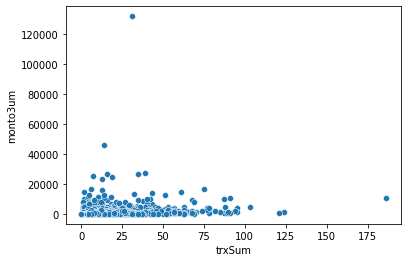

In [24]:
sns.scatterplot(data=dbFinal, x="trxSum", y="monto3um")
plt.show()

Veremos la correlación de trxSum y Monto3um para verificar si existe una relación entre ellas

In [25]:
print('********Correlación de Pearson********')
print(dbFinal[['trxSum','monto3um']].corr())
print('****Correlación de Pearson acotando los valores extremos****')
print(dbFinal[(dbFinal['monto3um']<40000) & (dbFinal['trxSum']<100)][['trxSum','monto3um']].corr())

********Correlación de Pearson********
            trxSum  monto3um
trxSum    1.000000  0.247905
monto3um  0.247905  1.000000
****Correlación de Pearson acotando los valores extremos****
            trxSum  monto3um
trxSum    1.000000  0.360044
monto3um  0.360044  1.000000


Podemos notar que la correlación es muy baja, eso implica que:

    - Realizar más transacciones por tarjeta no significa que el cliente consuma más.
    - Realizar menos transacciones por tarjeta no significa que el cliente consuma menos.

Procederemos a segmentar estas dos variables en conjunto, utilizando Kmodes y Kmeans para ver cuál es más efectiva.


#### Segmentando trxSum y Monto3um por Kmodes

In [26]:
from kmodes.kmodes import KModes
from sklearn import preprocessing

In [27]:
dbPrueba = pd.DataFrame()
dbPrueba = dbFinal[['trxSum','monto3um']].copy()
dbPrueba

,trxSum,monto3um
0,7.0,278.000000
1,1.0,228.000000
2,13.0,844.000000
3,35.0,1650.666667
4,1.0,7.000000
...,...,...
13827,0.0,0.000000
13828,0.0,0.000000
13829,0.0,0.000000
13830,0.0,0.000000


In [28]:
cost=[]
cluster=[]

for i in list(range(1,20)):
    model = KModes(n_clusters=i, init='Cao', n_init=1, verbose=1)
    cluster.append(model.fit_predict(dbPrueba))
    cost.append(model.cost_)
print(model.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 21614.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 28, cost: 20151.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 28, cost: 18844.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 37, cost: 17614.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 37, cost: 16685.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 35, cost: 15939.0
Run 1, iteration: 2/100, moves: 5, cost: 15939.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 25, cost: 15904.0
Run 1, iteration: 2/100, moves: 5, cost: 1

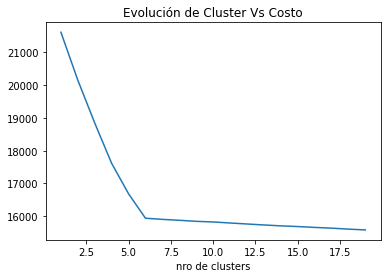

In [29]:
rango=np.array(range(1,len(cost)+1))
plt.plot(rango,cost)
plt.title('Evolución de Cluster Vs Costo')
plt.xlabel('nro de clusters')
plt.show()

In [30]:
n_cluster = 6
dbPrueba['cluster'] = cluster[n_cluster-1]
dbPrueba.head()

,trxSum,monto3um,cluster
0,7.0,278.000000,0
1,1.0,228.000000,1
2,13.0,844.000000,0
3,35.0,1650.666667,0
4,1.0,7.000000,1


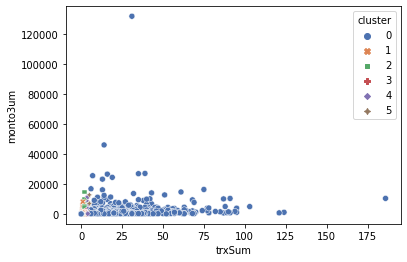

In [31]:
sns.scatterplot(data=dbPrueba, x="trxSum", y="monto3um",
                hue='cluster', palette="deep", alpha=1,
                style='cluster')
plt.show()

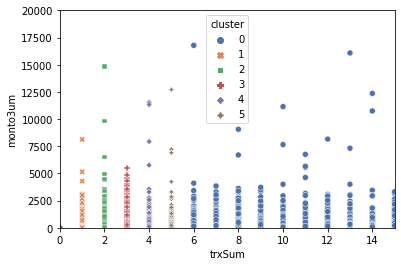

In [32]:
sns.scatterplot(data=dbPrueba, x="trxSum", y="monto3um",
                hue='cluster', palette="deep", alpha=1,
                style='cluster')
plt.xlim([0,15])
plt.ylim([0,20000])
plt.show()

**Kmodes a pesar de ser robusta a los outliers, en este caso la segmentación no tiene sentido, por tanto, no es un buen resultado, ni usaremos kmodes para el agrupamiento de estas dos variables.**

### Segmentando trxSum y Monto3um por Kmeans

***En este caso aguparemos sin contar con los valores muy extremos, ya que el método de Kmeans es sensible a dichos valores y pueden sesgar nuestra forma de agrupamiento.***

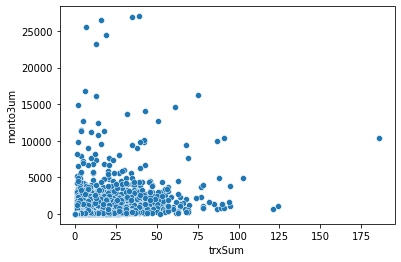

In [33]:
dbPrueba = dbPrueba.drop(dbPrueba[dbPrueba['monto3um']>40000].index)

sns.scatterplot(data=dbPrueba, x="trxSum", y="monto3um")
plt.show()

In [34]:
from sklearn.cluster import KMeans

cost=[]
cluster=[]

for i in list(range(1,11)):
    kmeans = KMeans(n_clusters=i, max_iter=300, random_state=1)
    kmeans.fit(dbPrueba)
    cluster.append(kmeans.fit_predict(dbPrueba))
    cost.append(kmeans.inertia_)

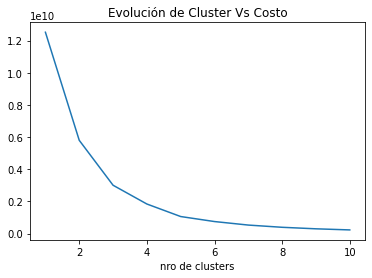

In [35]:
rango=np.array(range(1,len(cost)+1))
plt.plot(rango,cost)
plt.title('Evolución de Cluster Vs Costo')
plt.xlabel('nro de clusters')
plt.show()

In [36]:
n_cluster = 3
dbPrueba['cluster'] = cluster[n_cluster-1]
dbPrueba.head()

,trxSum,monto3um,cluster
0,7.0,278.000000,0
1,1.0,228.000000,0
2,13.0,844.000000,0
3,35.0,1650.666667,2
4,1.0,7.000000,0


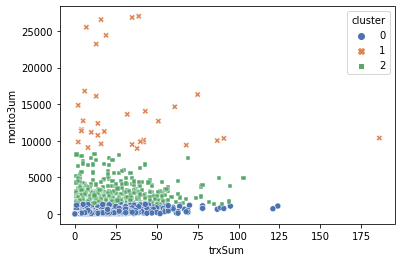

In [37]:
sns.scatterplot(data=dbPrueba, x="trxSum", y="monto3um",
                hue='cluster', palette="deep", alpha=1,
                style='cluster')
plt.show()

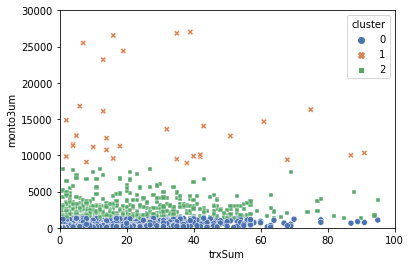

In [38]:
sns.scatterplot(data=dbPrueba, x="trxSum", y="monto3um",
                hue='cluster', palette="deep", alpha=1,
                style='cluster')
plt.xlim([0,100])
plt.ylim([0,30000])
plt.show()

In [39]:
dbFinal['cluster'] = dbPrueba['cluster']
dbFinal.head()

,periodo,cliente,M_1,M_2,M_3,monto_1,monto_2,monto_3,trxSum,frec,rec,monto3um,cluster
0,2017-10-01,1,0,1,1,0.0,210.0,346.0,7.0,2,2,278.000000,0.0
1,2017-10-01,2,1,0,0,228.0,0.0,0.0,1.0,1,3,228.000000,0.0
2,2017-10-01,3,1,1,1,1691.0,586.0,255.0,13.0,3,3,844.000000,0.0
3,2017-10-01,4,1,1,1,2650.0,1701.0,601.0,35.0,3,3,1650.666667,2.0
4,2017-10-01,5,0,1,0,0.0,7.0,0.0,1.0,1,2,7.000000,0.0


**La segmentación por Kmeans tiene más sentido, ya que agrupa las dos variables en base al monto.**

## 5.2 Etiqueta de trxSum y monto3um

In [40]:
dbFinal['monto_x_tran']= np.where(dbFinal['cluster']==2, '2. mediano consumo',
                         np.where(dbFinal['cluster']==1, '3. alto consumo',
                         np.where(dbFinal['cluster']==0, '1. bajo consumo', 'None',)))

In [41]:
dbFinal = dbFinal.drop(dbFinal[dbFinal['monto3um']>40000].index)
dbFinal.head()

,periodo,cliente,M_1,M_2,M_3,monto_1,monto_2,monto_3,trxSum,frec,rec,monto3um,cluster,monto_x_tran
0,2017-10-01,1,0,1,1,0.0,210.0,346.0,7.0,2,2,278.000000,0.0,1. bajo consumo
1,2017-10-01,2,1,0,0,228.0,0.0,0.0,1.0,1,3,228.000000,0.0,1. bajo consumo
2,2017-10-01,3,1,1,1,1691.0,586.0,255.0,13.0,3,3,844.000000,0.0,1. bajo consumo
3,2017-10-01,4,1,1,1,2650.0,1701.0,601.0,35.0,3,3,1650.666667,2.0,2. mediano consumo
4,2017-10-01,5,0,1,0,0.0,7.0,0.0,1.0,1,2,7.000000,0.0,1. bajo consumo


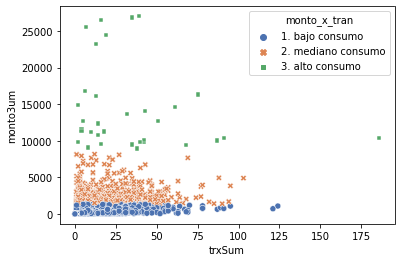

In [42]:
sns.scatterplot(data=dbFinal, x="trxSum", y="monto3um",
                hue='monto_x_tran', palette="deep", alpha=1,
                style='monto_x_tran')
plt.show()

In [43]:
dbFinal = dbFinal[['periodo','cliente','rec','frec','monto3um','trxSum','monto_x_tran']]
dbFinal.head()

,periodo,cliente,rec,frec,monto3um,trxSum,monto_x_tran
0,2017-10-01,1,2,2,278.000000,7.0,1. bajo consumo
1,2017-10-01,2,3,1,228.000000,1.0,1. bajo consumo
2,2017-10-01,3,3,3,844.000000,13.0,1. bajo consumo
3,2017-10-01,4,3,3,1650.666667,35.0,2. mediano consumo
4,2017-10-01,5,2,1,7.000000,1.0,1. bajo consumo


Eliminamos los valores anómalos.

In [44]:
dbFinal[((dbFinal['frec']>0) & (dbFinal['monto3um']==0))].head()

,periodo,cliente,rec,frec,monto3um,trxSum,monto_x_tran
4144,2017-10-01,10175,1,1,0.0,1.0,1. bajo consumo
7588,2017-10-01,20242,3,1,0.0,1.0,1. bajo consumo


In [45]:
dbFinal = dbFinal[~((dbFinal['frec']>0) & (dbFinal['monto3um']==0))]

## 5.3 Distribución RFM + t

Este paso nos dará la propuesta de la primera distribución o los grupos propuestos donde nuestros clientes están almacenados, es aquí donde surge el debate y analizan cuales serían los grupos finales para el negocio.

In [46]:
#nTotal = dbFinal.count()[0]
#dbRfm = dbFinal.groupby(['rec','frec','monto']).agg({'cliente':'count'}).sort_values(by=['rec','frec'], ascending=False)
nTotal = dbFinal[dbFinal['rec']>0].count()[0]
resumRfm = dbFinal[dbFinal['rec']>0].groupby(['rec','frec','monto_x_tran']).agg({'cliente':'count', 'monto3um':'sum'})\
                                 .sort_values(by=['rec','frec','monto_x_tran'], ascending=False)

resumRfm = resumRfm.reset_index()
resumRfm['%'] = round(100*resumRfm['cliente']/nTotal,1)
print(f'Clientes Total: {nTotal}\n')
print(resumRfm)

Clientes Total: 10804

    rec  frec        monto_x_tran  cliente      monto3um     %
0     3     3     3. alto consumo       23  3.253770e+05   0.2
1     3     3  2. mediano consumo      373  9.495517e+05   3.5
2     3     3     1. bajo consumo     4585  1.426960e+06  42.4
3     3     2     3. alto consumo        2  1.893650e+04   0.0
4     3     2  2. mediano consumo       86  1.885815e+05   0.8
5     3     2     1. bajo consumo     1944  4.306995e+05  18.0
6     3     1     3. alto consumo        5  6.373300e+04   0.0
7     3     1  2. mediano consumo       41  1.103000e+05   0.4
8     3     1     1. bajo consumo     1334  2.330020e+05  12.3
9     2     2     3. alto consumo        2  3.676500e+04   0.0
10    2     2  2. mediano consumo       40  1.032720e+05   0.4
11    2     2     1. bajo consumo      955  2.251220e+05   8.8
12    2     1     3. alto consumo        1  2.550000e+04   0.0
13    2     1  2. mediano consumo       28  6.781100e+04   0.3
14    2     1     1. bajo consum

In [47]:
#nTotal = dbFinal.count()[0]
#dbRfm = dbFinal.groupby(['rec','frec','monto']).agg({'cliente':'count'}).sort_values(by=['rec','frec'], ascending=False)
nTotal = dbFinal[dbFinal['rec']>0].count()[0]
resumRfm = dbFinal[dbFinal['rec']>0].groupby(['rec','frec','monto_x_tran']).agg({'cliente':'count', 'monto3um':'sum'})\
                                 .sort_values(by=['monto3um'], ascending=False)

resumRfm = resumRfm.reset_index()
resumRfm['%'] = round(100*resumRfm['cliente']/nTotal,1)
print(f'Clientes Total: {nTotal}\n')
print('************Tabla ordenada por el monto consumido(monto3um)************')
print()
print(resumRfm)

Clientes Total: 10804

************Tabla ordenada por el monto consumido(monto3um)************

    rec  frec        monto_x_tran  cliente      monto3um     %
0     3     3     1. bajo consumo     4585  1.426960e+06  42.4
1     3     3  2. mediano consumo      373  9.495517e+05   3.5
2     3     2     1. bajo consumo     1944  4.306995e+05  18.0
3     3     3     3. alto consumo       23  3.253770e+05   0.2
4     3     1     1. bajo consumo     1334  2.330020e+05  12.3
5     2     2     1. bajo consumo      955  2.251220e+05   8.8
6     3     2  2. mediano consumo       86  1.885815e+05   0.8
7     1     1     1. bajo consumo      714  1.284050e+05   6.6
8     2     1     1. bajo consumo      646  1.162060e+05   6.0
9     3     1  2. mediano consumo       41  1.103000e+05   0.4
10    2     2  2. mediano consumo       40  1.032720e+05   0.4
11    1     1  2. mediano consumo       25  8.055100e+04   0.2
12    2     1  2. mediano consumo       28  6.781100e+04   0.3
13    3     1     3. a

Analizaremos cada índice del dataframe ***resumRfm***, para justificar la segmentación.

Nota: El 0 indica el índice 0 del dataframe ***resumRfm*** donde:

        rec  frec        monto_x_tran  cliente      monto3um     %
    0     3     3  1. bajo comsumo     4585  1.426960e+06  42.4

0: Clientes frecuentes que debemos conservar e incentivar a que consuman más (***Posible Satisfecho***)

1: Clientes de mediano consumo y con preferencia por nuestro mercado (***Satisfecho***)

2: Clientes con bajo consumo debemos mejorar su presencia y consumo (***Bajo***)

3: Clientes top, estos clientes se deben mantener debido a su alto consumo y preferencia por nuestro mercado (***Cliente Estrella***)

4: Clientes que nos consumieron en el mes más reciente, pero con un consumo bajo (***Bajo***)

5: Clientes que consumen poco y están perdiendo interés por nuestro mercado (***Bajo***)

6: Clientes con buen consumo y que si mejoramos su preferencia por nuestro mercado serían posibles clientes satisfechos (***Posible Satisfecho***)

7: Clientes con bajo consumo y poco interés en nuestro mercado (***Bajo***)

8: Clientes con bajo consumo y poco interés en nuestro mercado  (***Bajo***)

9: Cliente con buen consumo y reciente presencia en nuestro mercado, si consolidamos su preferencia en nuestro mercado serían posibles clientes satisfechos (***Posible Satisfecho***)

10: Cliente con buen consumo y con presencia en nuestro mercado, si consolidamos su preferencia en nuestro mercado serían posibles clientes satisfechos  (***Posible Satisfecho***)

11: Clientes con buen consumo y están perdiendo interés en nuestro mercado (***Insatisfecho***)

12: Clientes con buen consumo y están perdiendo interés en nuestro mercado (***Insatisfecho***)

13: Nuevo cliente posible top debido a su alto consumo hay potencial aquí (***Posible Cliente Estrella***)

14: Clientes que no se deben perder ya que son buenos clientes debido a su alto consumo y han visitado nuestro mercado en los 2 anteriores mese, se debe incentivar (***Posible Cliente Estrella***)

15: Cliente ocasional con potencial a ser cliente estrella (***Posible Cliente Estrella***)

16: Clientes que si llegamos a consolidar su preferencia por nuestro mercado, se convertiría en un cliente estrella (***Posible Cliente Estrella***)

***TENEMOS 6 GRUPOS DE CLIENTES, ESTOS SON:***

    - 1. Bajo
    - 2. Insatisfecho
    - 3. Posible Satisfecho
    - 4. Satisfecho
    - 5. Potencial Estrella
    - 6. Estrella

        rec  frec        monto_x_tran  cliente      monto3um     %
        
    2     3     2     1. bajo consumo     1944  4.306995e+05  18.0 : Bajo
    4     3     1     1. bajo consumo     1334  2.330020e+05  12.3 : Bajo
    5     2     2     1. bajo consumo      955  2.251220e+05   8.8 : Bajo
    7     1     1     1. bajo consumo      714  1.284050e+05   6.6 : Bajo
    8     2     1     1. bajo consumo      646  1.162060e+05   6.0 : Bajo
    
    11    1     1  2. mediano consumo       25  8.055100e+04   0.2 : Insatisfecho
    12    2     1  2. mediano consumo       28  6.781100e+04   0.3 : Insatisfecho
    
    0     3     3     1. bajo consumo     4585  1.426960e+06  42.4 : Posible Satisfecho
    6     3     2  2. mediano consumo       86  1.885815e+05   0.8 : Posible Satisfecho
    9     3     1  2. mediano consumo       41  1.103000e+05   0.4 : Posible Satisfecho
    10    2     2  2. mediano consumo       40  1.032720e+05   0.4 : Posible Satisfecho
    
    1     3     3  2. mediano consumo      373  9.495517e+05   3.5 : Satisfecho
    
    13    3     1     3. alto consumo        5  6.373300e+04   0.0 : Posible Cliente Estrella
    14    2     2     3. alto consumo        2  3.676500e+04   0.0 : Posible Cliente Estrella
    15    2     1     3. alto consumo        1  2.550000e+04   0.0 : Posible Cliente Estrella
    16    3     2     3. alto consumo        2  1.893650e+04   0.0 : Posible Cliente Estrella
    
    3     3     3     3. alto consumo       23  3.253770e+05   0.2 : Cliente Estrella

# 6. RFM método Clásico o Experto

***A partir de la base de datos construída, y luego de analizar las distribuciones, se concluirán los nombres de los grupos conjuntamente con las características de la frecuencia, recencia y monto.***

Este análisis se realizó teniendo en cuenta la experiencia del analista en el negocio el cual puede identificar los grupos con la información dada y apuntando lo que necesita.


## 6.1 Etiqueta de los segmentos:

In [48]:
dbRfm = pd.DataFrame()
dbRfm = dbFinal[dbFinal['rec']>0].copy()

In [49]:
dbRfm.loc[(dbRfm['rec']==3)&(dbRfm['frec']==2)&(dbRfm['monto_x_tran']=='1. bajo consumo'),'rfm_t'] = '1. Bajo'
dbRfm.loc[(dbRfm['rec']==3)&(dbRfm['frec']==1)&(dbRfm['monto_x_tran']=='1. bajo consumo'),'rfm_t'] = '1. Bajo'
dbRfm.loc[(dbRfm['rec']==2)&(dbRfm['frec']==2)&(dbRfm['monto_x_tran']=='1. bajo consumo'),'rfm_t'] = '1. Bajo'
dbRfm.loc[(dbRfm['rec']==1)&(dbRfm['frec']==1)&(dbRfm['monto_x_tran']=='1. bajo consumo'),'rfm_t'] = '1. Bajo'
dbRfm.loc[(dbRfm['rec']==2)&(dbRfm['frec']==1)&(dbRfm['monto_x_tran']=='1. bajo consumo'),'rfm_t'] = '1. Bajo'

dbRfm.loc[(dbRfm['rec']==1)&(dbRfm['frec']==1)&(dbRfm['monto_x_tran']=='2. mediano consumo'),'rfm_t'] = '2. Insatisfecho'
dbRfm.loc[(dbRfm['rec']==2)&(dbRfm['frec']==1)&(dbRfm['monto_x_tran']=='2. mediano consumo'),'rfm_t'] = '2. Insatisfecho'

dbRfm.loc[(dbRfm['rec']==3)&(dbRfm['frec']==3)&(dbRfm['monto_x_tran']=='1. bajo consumo'),'rfm_t'] = '3. Posible Satisfecho'
dbRfm.loc[(dbRfm['rec']==3)&(dbRfm['frec']==2)&(dbRfm['monto_x_tran']=='2. mediano consumo'),'rfm_t'] = '3. Posible Satisfecho'
dbRfm.loc[(dbRfm['rec']==3)&(dbRfm['frec']==1)&(dbRfm['monto_x_tran']=='2. mediano consumo'),'rfm_t'] = '3. Posible Satisfecho'
dbRfm.loc[(dbRfm['rec']==2)&(dbRfm['frec']==2)&(dbRfm['monto_x_tran']=='2. mediano consumo'),'rfm_t'] = '3. Posible Satisfecho'

dbRfm.loc[(dbRfm['rec']==3)&(dbRfm['frec']==3)&(dbRfm['monto_x_tran']=='2. mediano consumo'),'rfm_t'] = '4. Satisfecho'

dbRfm.loc[(dbRfm['rec']==3)&(dbRfm['frec']==1)&(dbRfm['monto_x_tran']=='3. alto consumo'),'rfm_t'] = '5. Posible Estrella'
dbRfm.loc[(dbRfm['rec']==2)&(dbRfm['frec']==2)&(dbRfm['monto_x_tran']=='3. alto consumo'),'rfm_t'] = '5. Posible Estrella'
dbRfm.loc[(dbRfm['rec']==2)&(dbRfm['frec']==1)&(dbRfm['monto_x_tran']=='3. alto consumo'),'rfm_t'] = '5. Posible Estrella'
dbRfm.loc[(dbRfm['rec']==3)&(dbRfm['frec']==2)&(dbRfm['monto_x_tran']=='3. alto consumo'),'rfm_t'] = '5. Posible Estrella'

dbRfm.loc[(dbRfm['rec']==3)&(dbRfm['frec']==3)&(dbRfm['monto_x_tran']=='3. alto consumo'),'rfm_t'] = '6. Estrella'

## 6.2 Conclusión de segmento:

Le damos los nombres según características

In [50]:
resum = dbRfm.groupby('rfm_t').agg({'cliente':'count','rec':'mean','frec':'mean','monto3um':'sum', 'trxSum':'sum'})\
                                 .sort_values(by='rfm_t')
resum = resum.reset_index()
resum['%_cliente'] = round(100*resum['cliente']/dbRfm.count()[0],1)
resum['%_consumo'] = round(100*resum['monto3um']/dbRfm.monto3um.sum(),1)
print(f'Clientes Total: {dbRfm.count()[0]}\n')
print(resum)

Clientes Total: 10804

                   rfm_t  cliente       rec      frec      monto3um   trxSum  \
0                1. Bajo     5593  2.458430  1.518326  1.133434e+06  21357.0   
1        2. Insatisfecho       53  1.528302  1.000000  1.483620e+05    171.0   
2  3. Posible Satisfecho     4752  2.991582  2.956229  1.829114e+06  58791.0   
3          4. Satisfecho      373  3.000000  3.000000  9.495517e+05  10216.0   
4    5. Posible Estrella       10  2.700000  1.400000  1.449345e+05    116.0   
5            6. Estrella       23  3.000000  3.000000  3.253770e+05   1020.0   

   %_cliente  %_consumo  
0       51.8       25.0  
1        0.5        3.3  
2       44.0       40.4  
3        3.5       21.0  
4        0.1        3.2  
5        0.2        7.2  


Visualizamos los segmentos RFM + t para el universo de nuestros clientes, esta distribución será referente para los siguientes meses en que se realice la réplica del estudio.


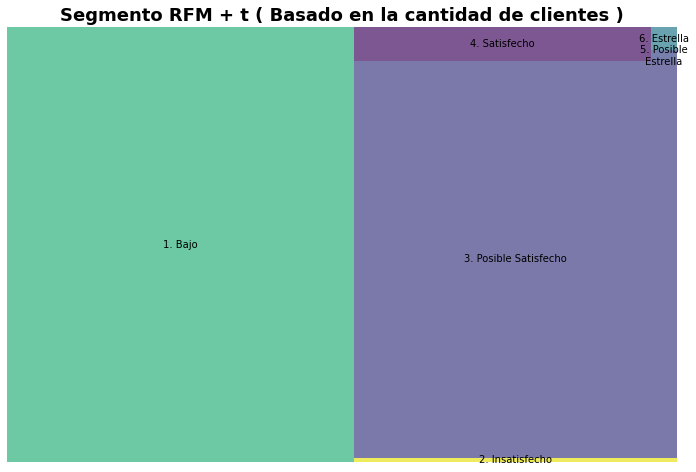

In [51]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(12, 8)
squarify.plot(sizes=resum['%_cliente'], 
              label=['1. Bajo', # Coloque los nombres que usted ha definido
                     '2. Insatisfecho',
                     '3. Posible Satisfecho',
                     '4. Satisfecho',
                     '5. Posible\nEstrella',
                     '6. Estrella'], alpha=0.7 )
plt.title("Segmento RFM + t ( Basado en la cantidad de clientes )",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

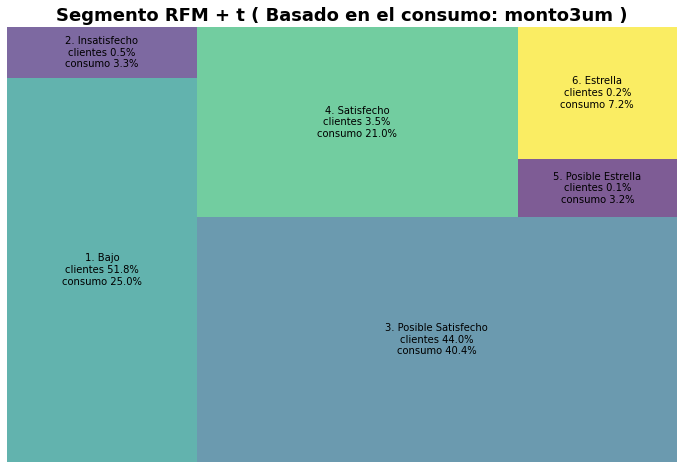

In [52]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(12, 8)
squarify.plot(sizes=resum['%_consumo'], 
              label=['1. Bajo\nclientes 51.8%\nconsumo 25.0%', # Coloque los nombres que usted ha definido
                     '2. Insatisfecho\nclientes 0.5%\nconsumo 3.3%',
                     '3. Posible Satisfecho\nclientes 44.0%\nconsumo 40.4%',
                     '4. Satisfecho\nclientes 3.5%\nconsumo 21.0%',
                     '5. Posible Estrella\nclientes 0.1%\nconsumo 3.2%',
                     '6. Estrella\nclientes 0.2%\nconsumo 7.2%'], alpha=0.7 )
plt.title("Segmento RFM + t ( Basado en el consumo: monto3um )",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

# Método RFM Clásico

El método RFM + t Clásico dió como resultado segmentar y detectar que un 3.8% de clientes (Estrella, Posible Estrella y Satisfecho) representan el 31.4% del consumo; además que el 47.8% de clientes (Satisfecho, Insatisfecho, Posible Satisfecho, Estrella y Posible Estrella) representan el 71.8% de consumo cumpliéndose una especie de ley de pareto donde el 20% de clientes hace el 80% de compras, además este método nos permitió hacer una segmentación más minusiosa y detallada de los tipos de clientes.

En resumen, resultó muy útil debido a que se detecto a la población que consume más en nuestro mercado, siendo esto muy útil, ya que nuestra campaña se podría dirigir mejor hacia esta clase de clientes, para que mejoren su consumo y mantener su preferencia por nuestro mercado.